In [1]:
#We need to load pandas:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
from scipy import stats
import seaborn as sns
from collections import Counter
import statistics
from sklearn.impute import SimpleImputer
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler

## Explanatory data analysis

First we read the data. You must change the path to the file path in your machine:

In [2]:
train_data = pd.read_csv('C:/Users/mhajiha/Desktop/State Farm/exercise_40_train.csv'
                         ,index_col=None )

look at the first 10 rows:

In [3]:
train_data.head(10)

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
0,0,0.165254,18.060003,Wed,1.077380,-1.339233,-1.584341,0.0062%,0.220784,1.816481,...,-0.397427,0.909479,no,5.492487,NaN,10.255579,7.627730,0,yes,104.251338
1,1,2.441471,18.416307,Friday,1.482586,0.920817,-0.759931,0.0064%,1.192441,3.513950,...,0.656651,9.093466,no,3.346429,4.321172,NaN,10.505284,1,yes,101.230645
2,1,4.427278,19.188092,Thursday,0.145652,0.366093,0.709962,-8e-04%,0.952323,0.782974,...,2.059615,0.305170,no,4.456565,NaN,8.754572,7.810979,0,yes,109.345215
3,0,3.925235,19.901257,Tuesday,1.763602,-0.251926,-0.827461,-0.0057%,-0.520756,1.825586,...,0.899392,5.971782,no,4.100022,1.151085,NaN,9.178325,1,yes,103.021970
4,0,2.868802,22.202473,Sunday,3.405119,0.083162,1.381504,0.0109%,-0.732739,2.151990,...,3.003595,1.046096,yes,3.234033,2.074927,9.987006,11.702664,0,yes,92.925935
5,0,1.926053,19.524376,Saturday,3.702574,2.300792,-0.331106,0.0079%,3.085443,0.472701,...,-0.689223,5.253010,no,NaN,NaN,9.882197,5.632881,0,NaN,97.129172
6,0,0.094162,18.894755,Thursday,2.027918,1.580408,1.190932,0.0174%,-0.331730,2.178622,...,1.095847,NaN,no,5.132039,0.973211,9.076239,9.197448,0,yes,89.613323
7,0,0.921300,19.160713,Sat,-1.274067,-0.867023,-2.036134,-0.0106%,2.830838,1.206701,...,-0.512785,1.986687,no,3.625493,-0.113036,12.495594,6.927711,0,yes,102.151914
8,0,0.589354,21.627989,Wednesday,1.672593,0.158446,2.073026,0.0032%,-0.908026,-0.064304,...,NaN,5.221553,no,4.270353,1.072603,9.789410,7.349307,0,yes,96.251348
9,0,1.016857,21.440000,Tuesday,-2.619848,0.637245,1.357868,0.0091%,1.471836,0.811922,...,NaN,7.427018,no,2.794465,0.219889,10.211048,10.970247,0,NaN,97.814997


Then we see how many rows and features are on this data:

In [4]:
train_data.shape    

(40000, 101)

The data has 40000 instances and 100 features. See the distribution of our target variable y:

In [5]:
train_data['y'].value_counts()

0    34197
1     5803
Name: y, dtype: int64

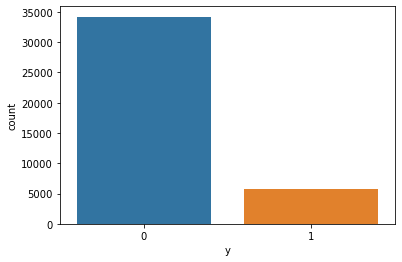

In [6]:
sns.countplot(train_data['y'])

The distribution of responses is highly unbalanced: 5803 ones to 34197 zeros. The will make it for any algorithm problems to find useful signals to classify the observations. For example if the model predicts all responses as zero, the is still a high accuracy. One way to deal with this problem is to optimize recall instead of accuracy. For an imbalanced class dataset F1 score is a more appropriate metric. It is the harmonic mean of precision and recall.
Recall is the proportion of 1s in the responses that are that are predicted as 1 by the model. Precision is the propoertions of truly 1-predicted responses that are perdicted as 1. Another way to deal with this problem is to downsample the majority group. 
In this case, taking a random sample without replacement is adequate. An informed undersampling is done by discrading some observations. Selecting observations to discard is tricky. a clustering algorithm i.g. k-NN can be implemented to get a downsampled dataset so that it contains observations of every natural group of data within the majority class. By this procedure, all the underlying information in the sample will be retained. Otherwise, downsampling may select all of one type of observation, and valuable information is lost. 

During the resampling, different ratios can be tried, as each class does not have to contain the same number of observations.
Here I consider a 0.5 - 0.5 ratio to make the distribution of classes balanced. Here I seperate x columns (predictors) and y column (response):

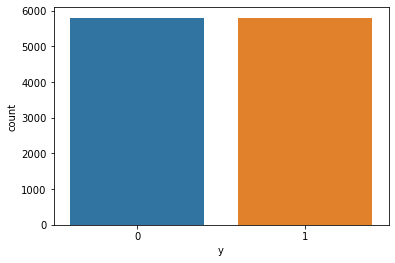

In [7]:
x_train = train_data.iloc[:, 1:]
y_train = train_data.iloc[:, 0]

from sklearn.utils import resample

'''
Here I seperate the minority observations from the majority:
'''
majority = train_data[(y_train==0)] 
minority = train_data[(y_train==1)] 
# downsample sample majority class
majority_downsampled = resample(majority, 
                                replace=True,    # sample with replacement
                                n_samples= 5803, # to match majority class
                                random_state=123)  # reproducible results
# Combine minority class with downsampled minority class
balanced_train_data = pd.concat([majority_downsampled, minority])

sns.countplot(balanced_train_data['y'])


Now we have a balanced data-set. Let's proceed. 

## Feature Engineering
The first step in a machine learning pipeline project is feature engineering. It includes removing or adding feuateus, combining feautures, imputing missing data, sacaling the data and clipping the outliers. 

So the first step in feature engineering is removing feaures that do not have a high correlation with observations. 


We could invoke the corr() function. Remember that negative correlation is still a correlation but here, we should look for values closer to -1 or +1:

In [8]:
balanced_train_data.corr()

,y,x1,x2,x4,x5,x6,x8,x9,x10,x11,...,x89,x90,x91,x92,x94,x95,x96,x97,x98,x100
y,1.000000,0.019280,0.007855,-0.001404,-0.043479,0.012600,-0.026730,0.002890,-0.002493,0.035934,...,-0.068173,0.018307,0.016345,0.012884,-0.000958,0.069910,-0.068985,0.015648,-0.016373,0.009127
x1,0.019280,1.000000,0.004029,-0.003843,0.004969,0.004857,-0.011906,0.007684,0.011509,-0.006231,...,-0.005603,0.011361,0.004331,-0.004012,-0.007542,-0.014053,0.001497,-0.004373,-0.001601,0.008573
x2,0.007855,0.004029,1.000000,0.055605,-0.174202,0.187758,0.002772,-0.300699,0.013087,-0.009442,...,-0.003186,-0.546107,0.149219,0.003832,-0.081097,-0.003073,0.009692,-0.024721,0.003967,-0.303892
x4,-0.001404,-0.003843,0.055605,1.000000,-0.024001,-0.066840,0.010606,-0.125802,0.009138,0.002283,...,-0.016887,-0.010532,0.155305,-0.004372,0.194729,-0.001258,0.000607,-0.119679,0.002800,-0.045505
x5,-0.043479,0.004969,-0.174202,-0.024001,1.000000,-0.184250,-0.003329,-0.101708,-0.010418,-0.017400,...,0.029634,0.002045,-0.202818,-0.011054,0.204574,0.030489,-0.028784,-0.171612,-0.004961,0.123951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x95,0.069910,-0.014053,-0.003073,-0.001258,0.030489,-0.006795,-0.122009,-0.007931,0.003130,-0.014462,...,0.350691,0.003802,-0.004719,0.000240,-0.007460,1.000000,-0.218310,0.000031,-0.021359,-0.008277
x96,-0.068985,0.001497,0.009692,0.000607,-0.028784,0.007586,0.147221,0.002320,-0.054518,0.134846,...,-0.099119,-0.028863,0.013460,0.006142,-0.022043,-0.218310,1.000000,-0.007084,0.006726,0.016965
x97,0.015648,-0.004373,-0.024721,-0.119679,-0.171612,0.044415,-0.011893,0.255252,0.008341,0.011194,...,-0.001260,0.007789,0.102765,0.001835,0.077902,0.000031,-0.007084,1.000000,-0.005615,-0.107396
x98,-0.016373,-0.001601,0.003967,0.002800,-0.004961,0.007359,-0.003964,-0.020412,-0.005110,-0.010071,...,-0.009141,0.014132,0.005882,-0.028917,-0.011893,-0.021359,0.006726,-0.005615,1.000000,0.002414


### Segragingt continous and categorical variables for special treatment:
Becuase there are 89*89 elements (feautes with missing values are automatically put aside in the correlation matrix, there is not much we can duduce by observation. Furthermore, The judgement may be subjective.
We need to resort to an automatic approach that filters out the variables that make difference in response. 


In this regard, let's first seperate the continuous and categorical features. To do that, let's see how many distinc values are in every feauture: 

In [9]:
for i,feature in enumerate(balanced_train_data.columns):
    if  balanced_train_data.iloc[:,i].nunique() < 500 :
        print(feature, balanced_train_data.iloc[:,i].nunique())

y 2
x3 14
x24 2
x31 2
x33 51
x39 1
x59 2
x60 12
x65 5
x77 7
x79 2
x93 2
x98 2
x99 1


Some features have only 1 value, let's eliminate them in place.

In [10]:
cat_feat = ['x39', 'x99']
balanced_train_data.drop(cat_feat, axis=1, inplace=True)

Now let's make a list of categorical features and seperate them. We need to treat them differently. Looking closely to data reveals that we have some features relating to U.S. states than count to at most 51 unique values. Features that have beyond this number of unique values are continous. Let's make the threshold equal to 500 so that to be safe if later on, other regions are added.

In [11]:
continuous_feat = []
categorical_feat = []
for i,feature in enumerate(balanced_train_data.columns):
    if balanced_train_data.iloc[:,i].nunique() > 500:
        continuous_feat.append(balanced_train_data.columns[i])
    else:
        categorical_feat.append(balanced_train_data.columns[i])

To adhere to the naming convention and to make statements shorter, let's name the train data as simply "df".

In [12]:
df = balanced_train_data.copy()  # copy by value not reference

Let's see the data types for the continuous features if they are not float64:

In [13]:
for i in continuous_feat:
    if  df[i].dtypes != "float64" : #most data type in this dataset are float64
       print(i, df[i] .dtypes)

x7 object
x19 object


Variables'x7' and 'x19' are non-numeric. Let's see them more closely:

In [14]:
df[['x7', 'x19']].head(5)

,x7,x19
18377,0.0023%,$-528.388126457053
32825,0.008%,$-629.966938922734
20747,-0.0099%,$-286.31196243064
17979,-0.0032%,$-1396.45736014961
9086,0.0047%,$-107.202473458502


Some continous features are str format. Let's make all continiuous features as float64.
variable 'x7' has a % sign and variable 'x19' has a $ sign. These two variables do not have NA values. Let's strip these values off of those signs and convert them to float. The indcies for these variables are not sequesntial. So I first make a list and then convert the values to float. Then copy the list back to the dataframe.

In [15]:
assert  df['x7'].isnull().sum() == 0  #make sure there is no null values
assert df['x19'].isnull().sum() == 0

In [16]:
x7 = list(df['x7'])
x19 = list(df['x19'])
x7 = [float(x7[i].replace('%',''))   for i in range(len(df))]
x19 = [float(x19[i].replace('$',''))   for i in range(len(df))]
df['x7'] = x7
df['x19'] = x19

### Missing values
Let's see how many nan values are in each feature:

In [17]:
num_na = []
for feature in df.columns:
    num_na.append(df[feature].isnull().sum())
    if df[feature].isnull().sum() > 0:
        print(feature,df[feature].isnull().sum())

x5 729
x11 1485
x14 2926
x16 3733
x22 707
x24 1069
x26 719
x30 9404
x33 2073
x38 713
x41 2789
x42 2711
x44 9936
x45 2315
x49 3689
x52 4675
x54 3614
x55 5107
x57 9455
x61 2109
x63 692
x64 1449
x67 721
x68 712
x74 3727
x75 1549
x76 1475
x77 2634
x78 3345
x79 728
x80 1493
x83 689
x85 2800
x86 667
x88 672
x89 3316
x91 1533
x92 716
x94 673
x95 3667
x96 2068


As you can see, meany of the features have na values. There are several strategies to fill missing values. 
For example, we can fill them by mean or median of non na values, but first we need to figure out if na values are are missing systematically. If they are missing systematically, then being missing can be a regraded as a feature. There are four kinds of missing vairbales:
    

**1-Missing at completely at random:** Being a missing value is like rolling a die. We may eliminate the missing variables or impute them.  

**2-Missing at random:** Being missing depends on the other existing predictors of the same response. The probability being missing depends only on other, fully recorded variables. We may only eliminate them when the regression controls
for all the variables that affect the probability of missingness. This missing-at-random assumption is casual.

**3-Missingness that depends on unobserved predictors:** Missingness is no longer “at random” if it depends on information that has not been recorded and this information also predicts the missing values. If missingness is not at random, it must be explicitly modeled, or else we must accept some bias in our inferences.

**4-Missingness that depends on the missing value itself:** Finally, a particularly difficult situation arises when the probability of missingness depends  on the (potentially missing) variable itself. This is called censoring. For example, people with higher earnings are less likely to reveal them. Including more predictors in the missing-data brings it closer to missing at random.


Generally it is very hard to disntinguish what category a missing values belongs to. One simplistic approach is imputing the missing values for continuous features with the mean value and imputing the missing values for categorical features with the mode of that feature. 

More sophisticated approach is to use linear regression or stochastic linear regression to regress the  missing data based on other predictors. 

Another approach is to find the similar data points and impute the missing data with the value the most similar data-point holds for that feature. Similarity can be regraded as Euclidean distance in the hyperplane of the variables space.

In this data-set, the nature of the other predictors is unknown, so we don't know how to regress the missing vlaues of a feature by other features. Let's take the simplistic approach at impute by mean. 

In [18]:
indicator_df = pd.DataFrame()
for feature in df.columns:
    my_imputer = SimpleImputer(strategy = 'most_frequent') # To impute the categorical features based on the most frequent
    df.groupby(df[feature].isnull())['y'].mean()
    missing_y = df[df[feature].isnull()]['y'].values.tolist()
    non_missing_y =  df[df[feature].notnull()]['y'].values.tolist()
    tstat, pval = stats.ttest_ind(missing_y, non_missing_y, equal_var=False)       
    if pval < 0.05:
        print("The hypothesis that feature {} is missing systematically is rejected by p-value = {:.3}".format(feature,pval))
        indicator_df['{}_indicator'.format(feature)] = df[feature].isnull()

    if feature in continuous_feat:
        df[feature] = df[feature].fillna( df[feature].mean())
    if feature in categorical_feat:
        new_array = df[feature].values.reshape(-1,1)
        data_new = my_imputer.fit_transform(new_array)
        df[feature] = data_new


The hypothesis that feature x16 is missing systematically is rejected by p-value = 1.95e-36
The hypothesis that feature x89 is missing systematically is rejected by p-value = 1.75e-07
The hypothesis that feature x96 is missing systematically is rejected by p-value = 1.19e-09


Features x16, x89, and x96 are not missing at random. In this situation we can make additional indicator variables that hold the value of 1 for mssing values and 0 for non-missing values. These variables are contributing to make indicator variables stored in a different data-frame called indicator_df.


Let's check the total number of missing values again:

In [19]:
num_na = []
for feature in df.columns:
    num_na.append(df[feature].isnull().sum())
print(sum(num_na))  

0


### Significant continuous variables:

In [20]:
global significant_feat 


significant_feat = []  # create an array to store significant variables

def describe_cont_feature(feature):
    print('\n*** Results for {} ***'.format(feature))
    print(df.groupby('y')[feature].describe())
    print(ttest(feature))
    
def ttest(feature):
    as_one = df[df['y']==1][feature]
    as_zero = df[df['y']==0][feature]
    tstat, pval = stats.ttest_ind(as_one, as_zero, equal_var=False)
    if pval < 0.05 : 
        significant_feat.append(feature)
    print('t-statistic: {:.1f}, p-value: {:.3}'.format(tstat, pval))

for feature in continuous_feat:
    describe_cont_feature(feature)


len(significant_feat)



*** Results for x1 ***
    count      mean       std       min       25%       50%       75%  \
y                                                                       
0  5803.0  2.982970  1.995359 -3.648431  1.598285  2.865714  4.231260   
1  5803.0  3.059679  1.982903 -2.500499  1.687725  2.949711  4.331014   

         max  
y             
0  12.891748  
1  11.147651  
t-statistic: 2.1, p-value: 0.0378
None

*** Results for x2 ***
    count       mean       std        min        25%        50%        75%  \
y                                                                            
0  5803.0  20.013407  1.609433  14.993739  18.946949  19.978338  21.092869   
1  5803.0  20.038727  1.614241  13.714945  18.950822  20.036757  21.105730   

         max  
y             
0  27.086468  
1  26.280843  
t-statistic: 0.8, p-value: 0.397
None

*** Results for x4 ***
    count      mean       std       min       25%       50%       75%  \
y                                                   

t-statistic: -0.8, p-value: 0.4
None

*** Results for x25 ***
    count      mean       std       min      25%       50%       75%  \
y                                                                      
0  5803.0  5.026787  2.423567 -2.134298  3.33510  4.879114  6.591027   
1  5803.0  4.997601  2.411744 -2.481233  3.28255  4.868005  6.525028   

         max  
y             
0  14.246155  
1  14.864223  
t-statistic: -0.7, p-value: 0.516
None

*** Results for x26 ***
    count      mean       std       min       25%       50%       75%  \
y                                                                       
0  5803.0  0.042429  1.508350 -5.686049 -0.910916  0.013091  0.996274   
1  5803.0 -0.016247  1.498391 -5.763695 -0.997773  0.013091  0.958849   

        max  
y            
0  6.696843  
1  5.752074  
t-statistic: -2.1, p-value: 0.0355
None

*** Results for x27 ***
    count         mean         std         min         25%          50%  \
y                                   

None

*** Results for x50 ***
    count         mean         std          min          25%          50%  \
y                                                                           
0  5803.0  2107.999731  951.809207 -1462.698091  1448.391712  2114.571057   
1  5803.0  2141.055891  928.456563 -1152.803005  1517.212940  2127.676221   

           75%          max  
y                            
0  2760.034594  5289.699155  
1  2755.494201  5561.314843  
t-statistic: 1.9, p-value: 0.0583
None

*** Results for x51 ***
    count      mean       std       min       25%       50%       75%  \
y                                                                       
0  5803.0  1.455856  1.570004 -3.270516  0.377386  1.347487  2.349507   
1  5803.0  1.557696  1.599808 -3.008517  0.462979  1.434351  2.520115   

         max  
y             
0   8.991812  
1  11.925995  
t-statistic: 3.5, p-value: 0.00054
None

*** Results for x52 ***
    count      mean       std        min       25%       50

t-statistic: 1.7, p-value: 0.0889
None

*** Results for x78 ***
    count       mean       std        min        25%        50%        75%  \
y                                                                            
0  5803.0  49.929721  3.450173  35.775105  48.496507  49.620578  51.581915   
1  5803.0  49.311435  3.527384  35.721012  47.597023  49.620578  50.793063   

         max  
y             
0  64.450959  
1  64.156829  
t-statistic: -9.5, p-value: 1.62e-21
None

*** Results for x80 ***
    count       mean       std       min       25%       50%        75%  \
y                                                                         
0  5803.0  10.004413  2.365974  2.361436  8.334422  10.04349  11.585320   
1  5803.0  10.082567  2.398662  2.453643  8.468549  10.04349  11.749928   

         max  
y             
0  16.814773  
1  17.189460  
t-statistic: 1.8, p-value: 0.0772
None

*** Results for x81 ***
    count      mean       std       min       25%       50%       75%  

42

In [21]:
significant_feat

['x1',
 'x5',
 'x7',
 'x8',
 'x11',
 'x16',
 'x18',
 'x19',
 'x21',
 'x26',
 'x27',
 'x28',
 'x32',
 'x35',
 'x36',
 'x40',
 'x41',
 'x44',
 'x46',
 'x47',
 'x48',
 'x49',
 'x51',
 'x52',
 'x53',
 'x56',
 'x57',
 'x62',
 'x63',
 'x64',
 'x68',
 'x70',
 'x75',
 'x78',
 'x81',
 'x85',
 'x87',
 'x88',
 'x89',
 'x90',
 'x95',
 'x96']

In [22]:
cont_sig = significant_feat

In [23]:
 categorical_feat= categorical_feat[1:]

We need to codify the categorical variables. We could import LabelEncoder from sklearn.preprocessing, but upon closely examining the data, I observed that a categorical features that holds the weakdays, use both full names of the days like "Monday" and in some instances it uses the first three letters like "Mon". So there are seemingly differenet categories that have the same meaning. Therefore, I decided to be more cautios and examine and encode the categorical variables one by one.

In [24]:
#Create a function to return a dictionary containing the unique values and the number of their repetitions:
def unique(list1):
    # Print directly by using * symbol
    return(Counter(list1))

In [25]:
print(unique(df['x3'])) # The number of unique variables

Counter({'Wednesday': 1276, 'Friday': 1261, 'Saturday': 1165, 'Sunday': 1154, 'Monday': 1115, 'Tuesday': 1044, 'Tue': 805, 'Thursday': 743, 'Wed': 701, 'Mon': 680, 'Thur': 530, 'Sat': 460, 'Fri': 453, 'Sun': 219})


In [26]:
dic = {'Sunday':1 ,'Sun' : 1,
                         'Monday':2 ,'Mon' : 2, 
                         'Tuesday' : 3,'Tue' : 3,
                         'Wednesday' :4,'Wed' : 4,
                         'Thursday' : 5,'Thur' : 5,
                         'Friday' : 6,'Fri' : 6,
                         'Saturday' : 7,'Sat' : 7}

#Encoding the unique variables using map function
df['x3'] = df['x3'].map(dic)



In [27]:
df['x3'].isnull().sum()

0

In [28]:
print(unique(df['x3'])) # The number of unique variables

Counter({4: 1977, 3: 1849, 2: 1795, 6: 1714, 7: 1625, 1: 1373, 5: 1273})


In [29]:
#x24 is male-female variable that can easily be encoded:
df['x24'].nunique()
df['x24'] = df['x24'].map({'male':0 ,'female' : 1})
print(df['x24'].nunique()) # The number of unique variables

2


In [30]:
# x31 is a yes-no variable:
unique(df['x31'])
print(df['x31'].nunique())
df['x31'] = df['x31'].map({'no':0 ,'yes' : 1})
unique(df['x31'])

2


Counter({0: 10165, 1: 1441})

In [31]:
# x31 is a yes-no variable:
print(df['x33'].nunique())
dic = unique(df['x33'])
states = list(dic.keys())
newdic = {x:i  for i,x in enumerate(states)   }
df['x33'] = df['x33'].map(newdic)
print(df['x33'].nunique()) # The number of unique variables

51
51


In [32]:
# x54 is a 0-1 variable:
print(df['x59'].nunique())
unique(df['x59'])

2


Counter({0: 10448, 1: 1158})

In [33]:
# x60 is the variables that records the months:
print(unique(df['x60']))
months_dict = unique(df['x60'])
months =  list(months_dict.keys())
newdic = {x:i  for i,x in enumerate(months)   }
df['x60'] = df['x60'].map(newdic)
unique(df['x60'])

Counter({'January': 2383, 'December': 2347, 'August': 2301, 'July': 2248, 'September': 365, 'February': 348, 'June': 342, 'November': 306, 'April': 266, 'March': 252, 'October': 231, 'May': 217})


Counter({0: 2383,
         1: 306,
         2: 2301,
         3: 266,
         4: 2248,
         5: 231,
         6: 2347,
         7: 365,
         8: 348,
         9: 342,
         10: 217,
         11: 252})

In [34]:
# x65 is a variables that records the insurnce companies involved:
print(unique(df['x65']))
comp_dict = unique(df['x65'])
companies =  list(comp_dict.keys())
newdic = {x:i  for i,x in enumerate(companies)   }
df['x65'] = df['x65'].map(newdic)
print(unique(df['x65']))

Counter({'progressive': 3229, 'allstate': 3100, 'esurance': 2088, 'farmers': 1602, 'geico': 1587})
Counter({4: 3229, 3: 3100, 1: 2088, 0: 1602, 2: 1587})


In [35]:
# x77 is a variables that records the car manufacturers involved:
print(unique(df['x77']))
car_dict = unique(df['x77'])
cars =  list(car_dict.keys())
newdic = {x:i  for i,x in enumerate(cars)   }
df['x77'] = df['x77'].map(newdic)
print(unique(df['x77']))

Counter({'ford': 5251, 'chevrolet': 1477, 'subaru': 1433, 'mercedes': 1324, 'toyota': 1042, 'nissan': 758, 'buick': 321})
Counter({1: 5251, 5: 1477, 4: 1433, 2: 1324, 0: 1042, 3: 758, 6: 321})


In [36]:
# x79 is float 0-1 variables. I made it as integer.
print(unique(df['x79']))
float_dict = unique(df['x79'])
floats =  list(float_dict.keys())
newdic = {x:i  for i,x in enumerate(floats)   }
df['x79'] = df['x79'].map(newdic)
print(unique(df['x79']))

Counter({1.0: 10487, 0.0: 1119})
Counter({0: 10487, 1: 1119})


In [37]:
# x93 is a yes-no variable:
print(unique(df['x93']))
ans_dict = unique(df['x93'])
ans =  list(ans_dict.keys())
newdic = {x:i  for i,x in enumerate(ans)   }
df['x93'] = df['x93'].map(newdic)
print(unique(df['x93']))

Counter({'no': 10580, 'yes': 1026})
Counter({0: 10580, 1: 1026})


Let's examin the categorical data visually (using seaborn catplot function) to see whether each of them make difference in the response variable:

In [38]:
df[categorical_feat].head(10)

,x3,x24,x31,x33,x59,x60,x65,x77,x79,x93,x98
18377,7,1,0,0,0,0,0,0,0,0,1
32825,6,1,0,1,0,1,1,1,0,0,1
20747,5,1,0,2,0,1,2,2,0,0,1
17979,2,0,0,3,0,2,3,2,0,0,1
9086,7,0,0,4,0,3,3,1,0,0,1
27811,2,0,0,5,0,4,4,3,0,0,0
26038,6,1,1,0,0,5,4,4,0,0,0
120,2,0,0,5,0,0,4,1,0,0,1
27120,3,1,1,6,0,3,3,3,0,1,0
6628,6,1,1,0,0,0,2,0,1,1,1


### Significant categorical variables:

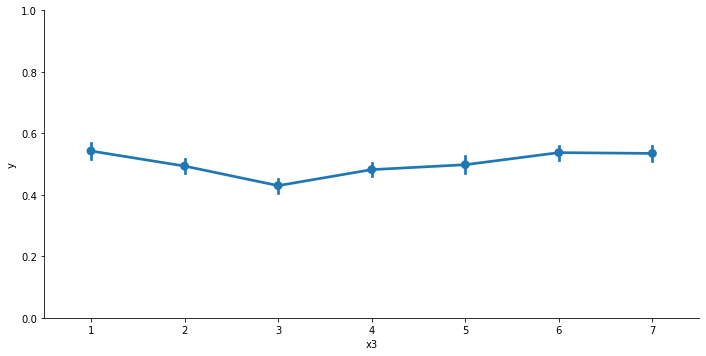

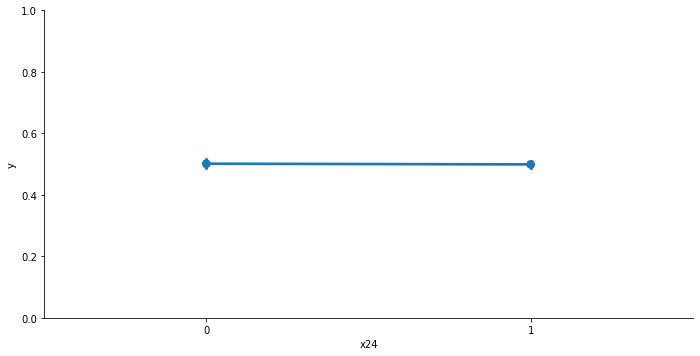

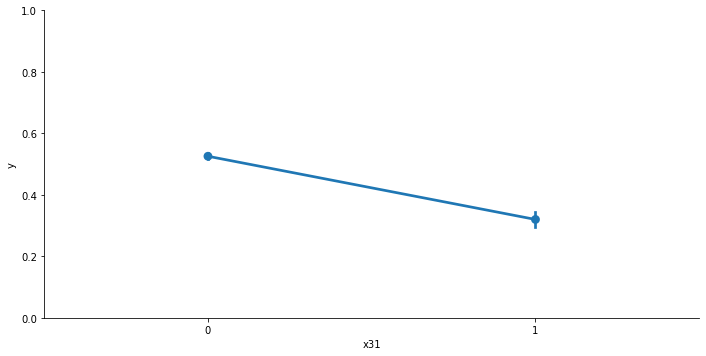

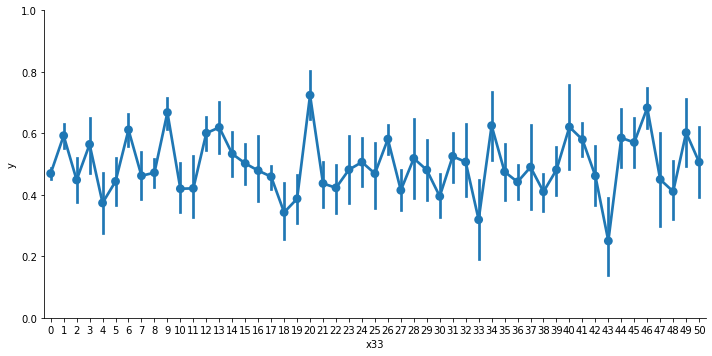

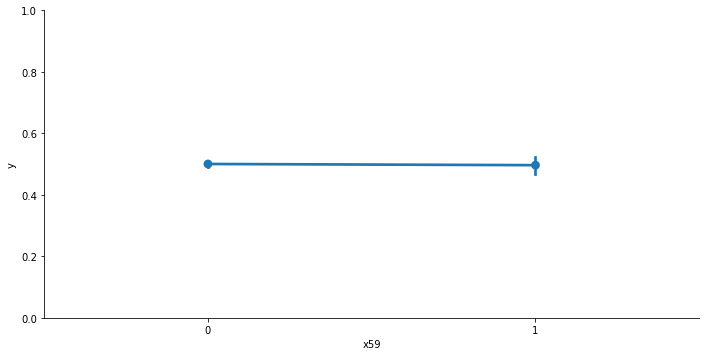

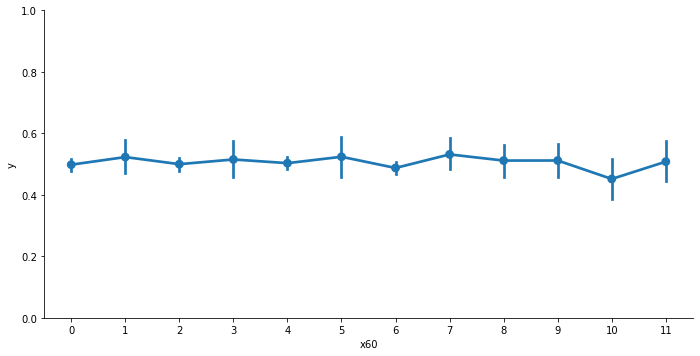

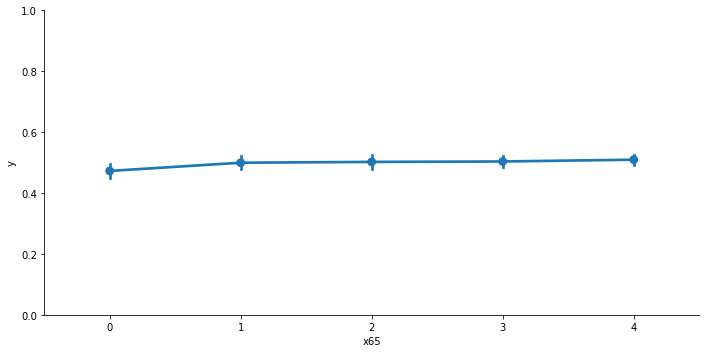

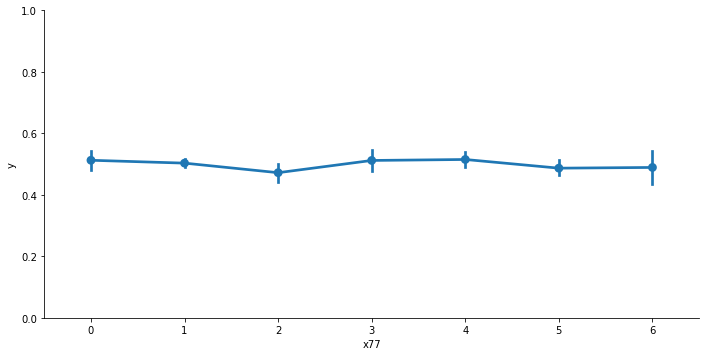

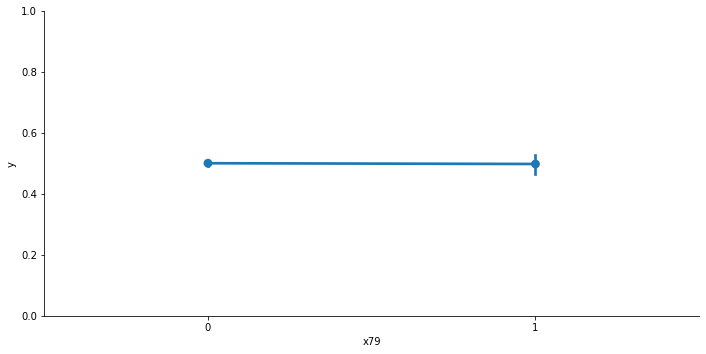

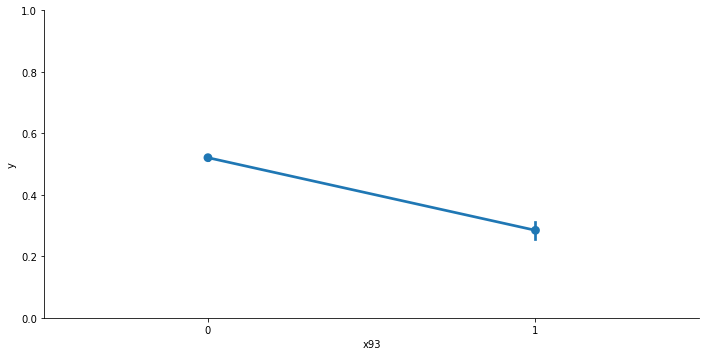

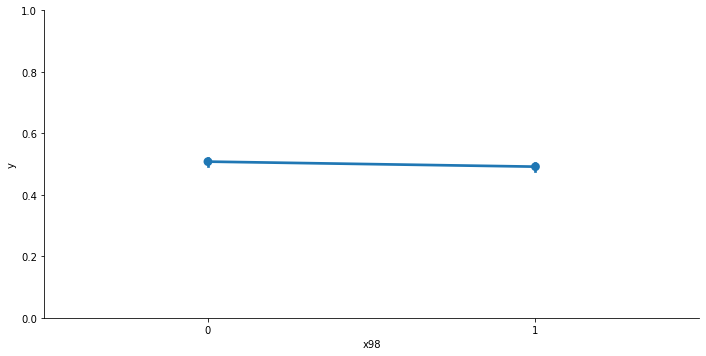

In [39]:
# Generate categorical plots for categorical features
for col in categorical_feat:
    sns.catplot(x=col, y='y', data=df, kind='point', aspect=2)
    plt.ylim(0, 1)

Upon seeing the categorical plots, only the following variables are affecting the response:

In [40]:
significant_categorical_feat  = ['x31', 'x33', 'x93']

Let's make a list of the variables that we are interested to keep so far. 
**We have 42 signifant variables that are continuous.**
**We have 3 significant variables that are categorical.**
**We have 3 indicator variables that we created on the proven hypothesis the missing values in some columns are not missing by random.**

In [41]:
#making a list of all variables that I need:
significant_feat.extend(significant_categorical_feat)

#Encode the indicatory variables by 0 and 1:
for feat in indicator_df.columns:
    indicator_df[feat] = indicator_df[feat].map({False:0 ,True : 1})
    
#append the indicator dataframe to the main dataframe:
for feat in indicator_df.columns:
    df[feat] = indicator_df[feat]


significant_feat.extend(indicator_df.columns)
    


Let's see the significant variables:

In [42]:
significant_feat

['x1',
 'x5',
 'x7',
 'x8',
 'x11',
 'x16',
 'x18',
 'x19',
 'x21',
 'x26',
 'x27',
 'x28',
 'x32',
 'x35',
 'x36',
 'x40',
 'x41',
 'x44',
 'x46',
 'x47',
 'x48',
 'x49',
 'x51',
 'x52',
 'x53',
 'x56',
 'x57',
 'x62',
 'x63',
 'x64',
 'x68',
 'x70',
 'x75',
 'x78',
 'x81',
 'x85',
 'x87',
 'x88',
 'x89',
 'x90',
 'x95',
 'x96',
 'x31',
 'x33',
 'x93',
 'x16_indicator',
 'x89_indicator',
 'x96_indicator']

### Capping outliers

Let's see the overlaid histograms for each continuous variable:

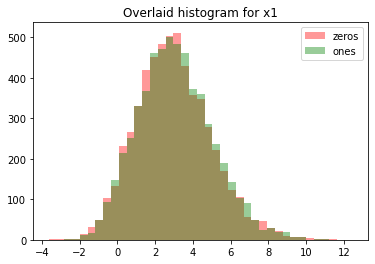

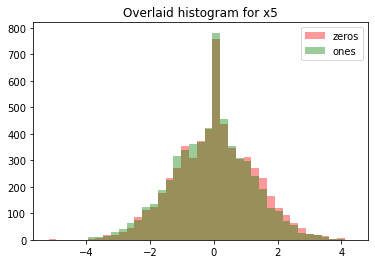

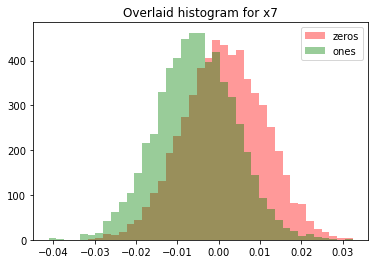

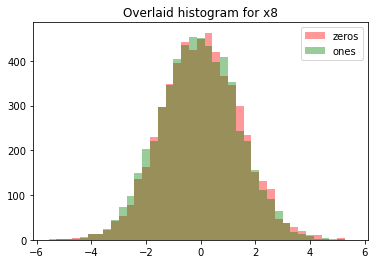

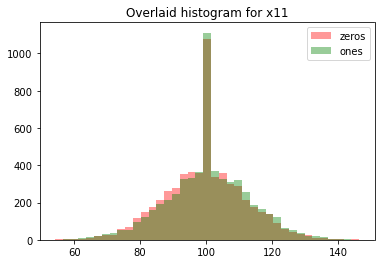

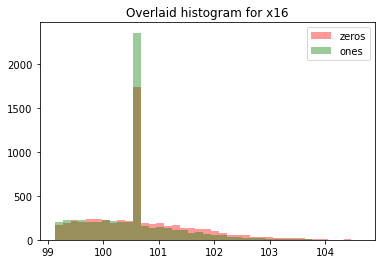

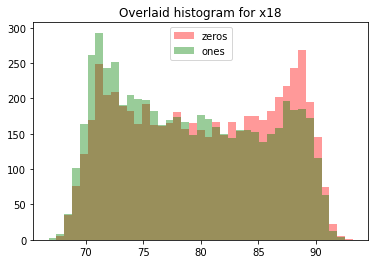

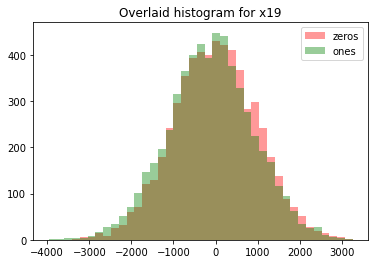

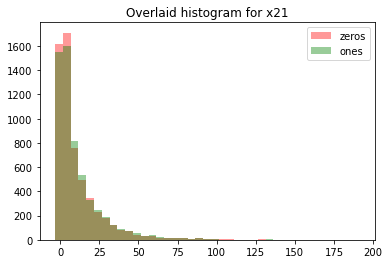

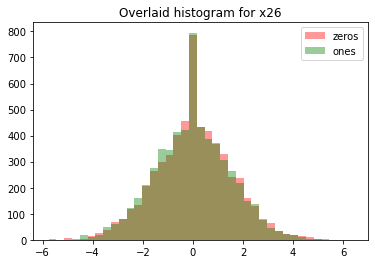

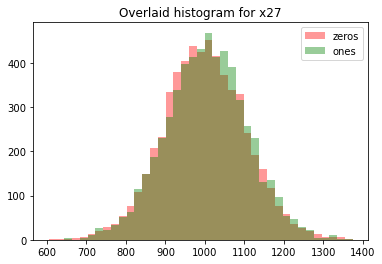

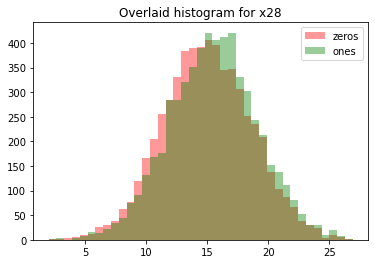

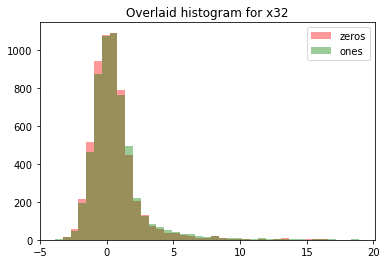

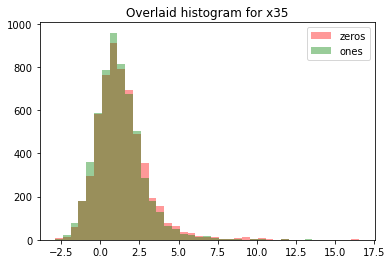

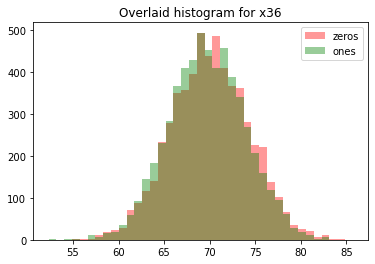

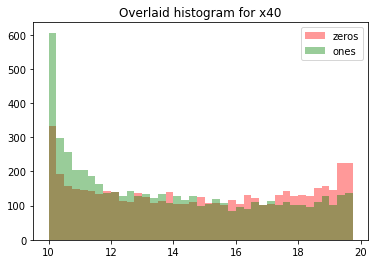

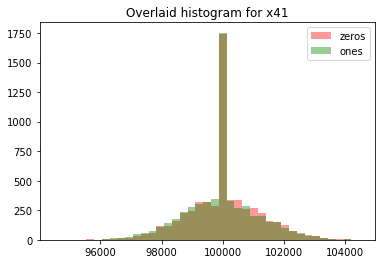

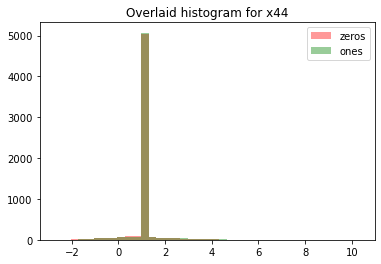

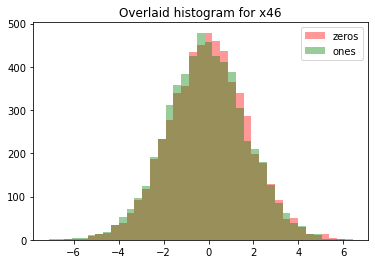

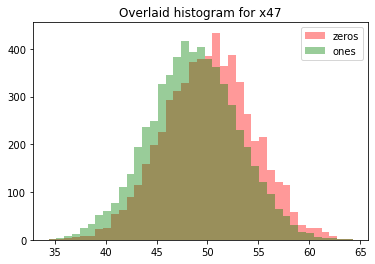

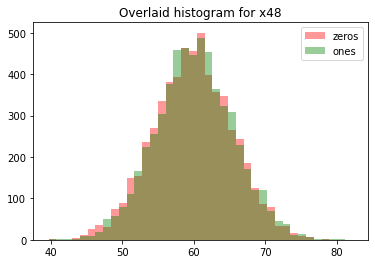

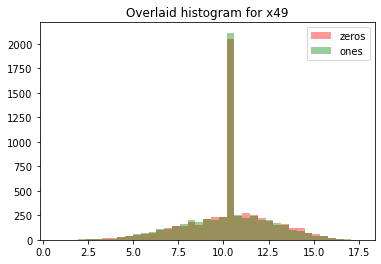

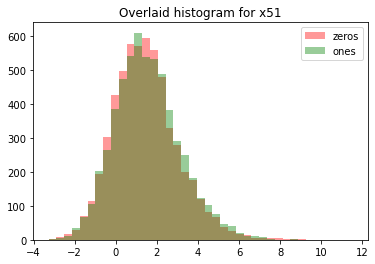

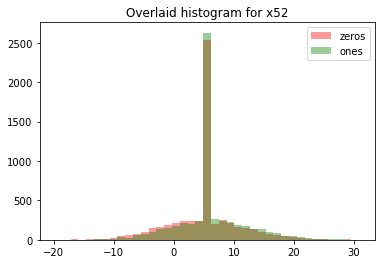

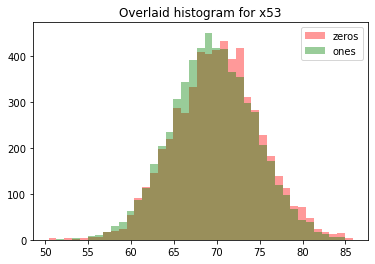

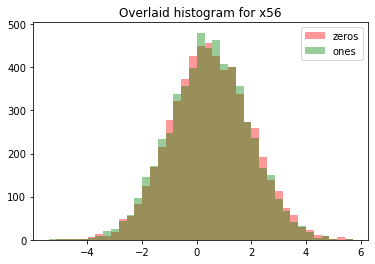

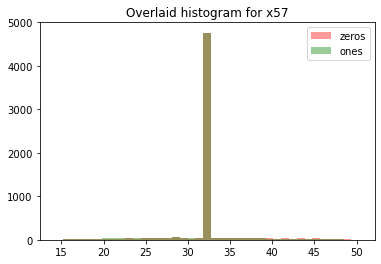

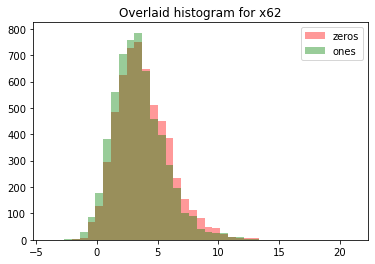

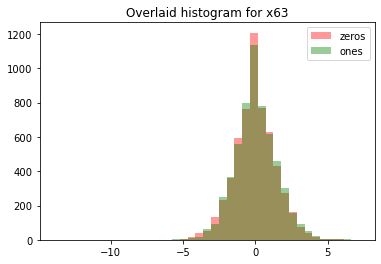

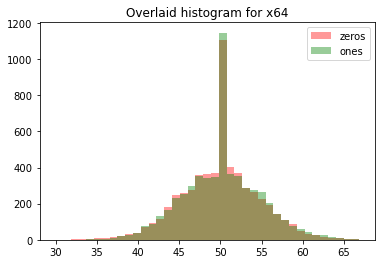

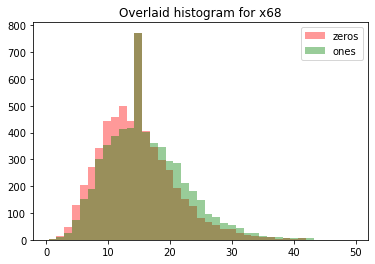

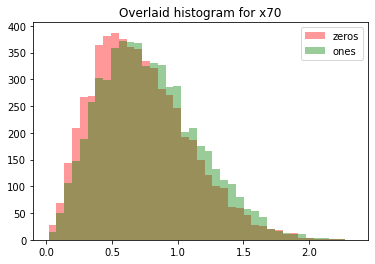

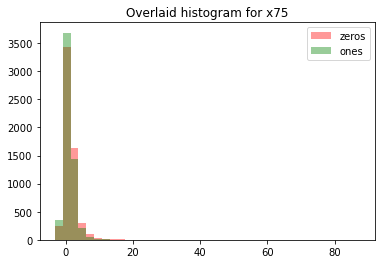

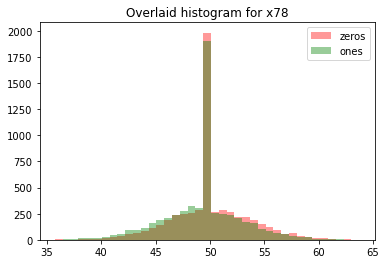

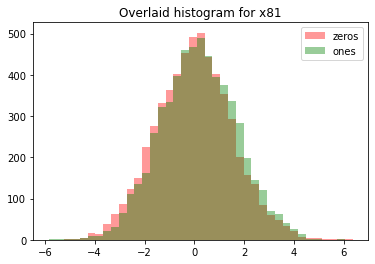

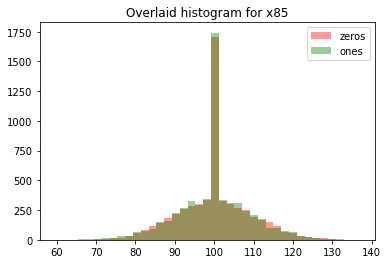

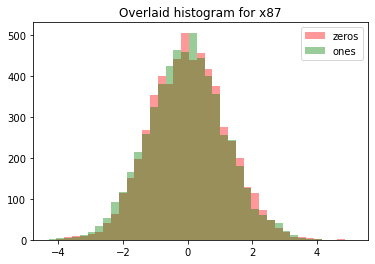

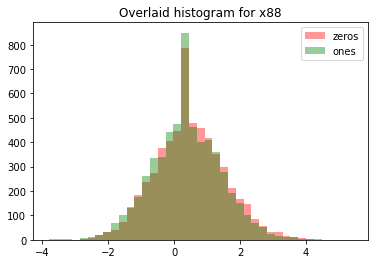

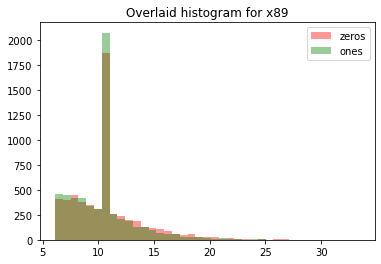

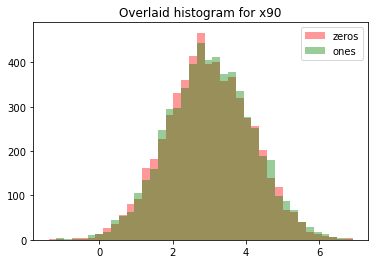

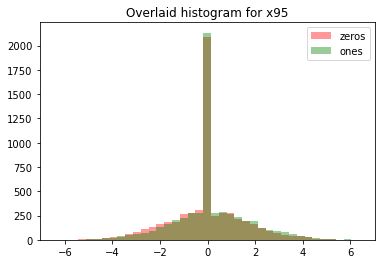

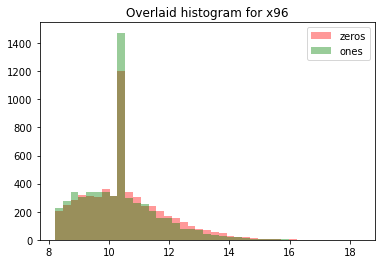

In [43]:
for i in continuous_feat:
    if i in significant_feat:
        zeros = list(df[df['y'] == 0][i].dropna())
        ones = list(df[df['y'] == 1][i].dropna())
        xmin = min(min(zeros), min(ones))
        xmax = max(max(zeros), max(ones))
        width = (xmax - xmin) / 40
        sns.distplot(zeros, color='r', kde=False, bins=np.arange(xmin, xmax, width))
        sns.distplot(ones, color='g', kde=False, bins=np.arange(xmin, xmax, width))
        plt.legend(['zeros', 'ones'])
        plt.title('Overlaid histogram for {}'.format(i))
        plt.show()

The overlaid histograms show that there is no or little diffrence between the distribution of obeservations that lead to response 0 and those that lead to response 1 for each variables. Also It is evident some of the variables have quite far outliers. Let's eliminate the outliers that are farther than 0.99% quantile. I used a function that shows how many values for each variable is beyond 0.9, beyond 3 time standard deviation and beyond 0.99 quantile of data on just the right side of the distributions. This gives us an estimate of how many variables are going to be capped.

In [44]:
def detect_outlier(feature):
    outliers = []
    data = df[feature]
    mean = np.mean(data)
    std =np.std(data)
    
    
    for y in data:
        z_score= (y - mean)/std 
        if np.abs(z_score) > 3:
            outliers.append(y)
            
    print('\nOutlier caps for {}:'.format(feature))
    print('  --95p: {:.1f} / {} values exceed that'.format(data.quantile(.95),
                                                             len([i for i in data
                                                                  if i > data.quantile(.95)])))
    print('  --3sd: {:.1f} / {} values exceed that'.format(mean + 3*(std), len(outliers)))
    print('  --99p: {:.1f} / {} values exceed that'.format(data.quantile(.99),
                                                           len([i for i in data
                                                                if i > data.quantile(.99)])))


In [45]:
# Determine what the upperbound should be for continuous features
for feat in significant_feat :
     detect_outlier(feat)
    


Outlier caps for x1:
  --95p: 6.5 / 581 values exceed that
  --3sd: 9.0 / 45 values exceed that
  --99p: 8.2 / 117 values exceed that

Outlier caps for x5:
  --95p: 2.0 / 581 values exceed that
  --3sd: 3.7 / 34 values exceed that
  --99p: 3.0 / 117 values exceed that

Outlier caps for x7:
  --95p: 0.0 / 579 values exceed that
  --3sd: 0.0 / 20 values exceed that
  --99p: 0.0 / 112 values exceed that

Outlier caps for x8:
  --95p: 2.3 / 581 values exceed that
  --3sd: 4.3 / 35 values exceed that
  --99p: 3.3 / 117 values exceed that

Outlier caps for x11:
  --95p: 120.7 / 581 values exceed that
  --3sd: 137.1 / 45 values exceed that
  --99p: 130.1 / 117 values exceed that

Outlier caps for x16:
  --95p: 102.2 / 581 values exceed that
  --3sd: 103.1 / 158 values exceed that
  --99p: 103.3 / 117 values exceed that

Outlier caps for x18:
  --95p: 89.6 / 581 values exceed that
  --3sd: 99.1 / 0 values exceed that
  --99p: 90.8 / 117 values exceed that

Outlier caps for x19:
  --95p: 1573.

Upon seeing the histograms, some variables are right skewed. For these variables upper 0.99 values are equalized to the 0.99 quantile. 
Some variables are roughly symmetric. For these variables, values lower than 0.01 and values upper than 0.99 quantile are equalized to the 0.01 and 0.99 bounds respectively.

In [46]:
extereme_high_outlier = ['x16','x21','x32','x35','x52','x62','x68','x70','x75','x89','x96']
both_end_extreme_outlier = ['x11','x41','x44','x49','x52','x57','x63','x64','x78','x85','x95']
    
for feat in extereme_high_outlier:
    df[feat].clip(upper=df[feat].quantile(.99), inplace = True)

for feat in both_end_extreme_outlier:
    df[feat].clip(upper=df[feat].quantile(.99), lower =df[feat].quantile(.1), inplace = True)
   

# Logistice regression on traning data

First, I select the variables that I filtered as significant:
Then, I seperate the variables and the responses:

In [47]:
chosen_df = df[significant_feat].copy()
df_x = chosen_df.iloc[:,1:]
df_y = df.iloc[:,0]

df_x.columns

Index(['x5', 'x7', 'x8', 'x11', 'x16', 'x18', 'x19', 'x21', 'x26', 'x27',
       'x28', 'x32', 'x35', 'x36', 'x40', 'x41', 'x44', 'x46', 'x47', 'x48',
       'x49', 'x51', 'x52', 'x53', 'x56', 'x57', 'x62', 'x63', 'x64', 'x68',
       'x70', 'x75', 'x78', 'x81', 'x85', 'x87', 'x88', 'x89', 'x90', 'x95',
       'x96', 'x31', 'x33', 'x93', 'x16_indicator', 'x89_indicator',
       'x96_indicator'],
      dtype='object')

First I scaled the data to make it easier for the model to pick up the signal. The raw data has different scales and we are just interested to now that for each values, how many standard deviation that values is below or above the mean of that variables.

In [48]:
scaler = StandardScaler()
scaler.fit(df_x)

StandardScaler()

Then, I import the Logistic regression model out of  sklearn.linear_model and also the GridSearchCV module out of sklearn.model_selection

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [50]:
chosen_df = df[significant_feat].copy()
df_x = chosen_df.iloc[:,1:]
df_y = df.iloc[:,0]

df_x.columns

Index(['x5', 'x7', 'x8', 'x11', 'x16', 'x18', 'x19', 'x21', 'x26', 'x27',
       'x28', 'x32', 'x35', 'x36', 'x40', 'x41', 'x44', 'x46', 'x47', 'x48',
       'x49', 'x51', 'x52', 'x53', 'x56', 'x57', 'x62', 'x63', 'x64', 'x68',
       'x70', 'x75', 'x78', 'x81', 'x85', 'x87', 'x88', 'x89', 'x90', 'x95',
       'x96', 'x31', 'x33', 'x93', 'x16_indicator', 'x89_indicator',
       'x96_indicator'],
      dtype='object')

Then I scale the variables using the scaler that I instantiated out of the scaler class:

In [51]:
# Fit the scaler on the training data
scaler = StandardScaler()
scaler.fit(df_x)

StandardScaler()

Let's mute the warnings:

In [52]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [53]:
with warnings.catch_warnings():
	# ignore all caught warnings
	warnings.filterwarnings("ignore")
	# execute code that will generate warnings

Here I created the function that output the results of the cross-validation. This is useful for hyperparameter tuning:

In [54]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))


Let's define training features and traning response:

In [55]:
tr_features = df_x
tr_labels = df_y

Using different values for the regularization parameter stores in a dictionary, let's fit the model on traning data:

In [56]:
lr = LogisticRegression()
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

cv = GridSearchCV(lr, parameters, cv=10)
cv.fit(tr_features, tr_labels.values.ravel())



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

Let's print out the results using the function that I created:

In [57]:
print_results(cv)

BEST PARAMS: {'C': 0.01}

0.589 (+/-0.03) for {'C': 0.001}
0.591 (+/-0.032) for {'C': 0.01}
0.587 (+/-0.03) for {'C': 0.1}
0.588 (+/-0.031) for {'C': 1}
0.588 (+/-0.031) for {'C': 10}
0.591 (+/-0.034) for {'C': 100}
0.589 (+/-0.036) for {'C': 1000}


It seems that regardless of the regularization parameter, the best result obtained is having an accuracy of 0.589. Using the best combination of hyper parameters the probability of the traning data belonging to each class is obtained by:

In [58]:
cv.predict_proba(tr_features)

array([[0.43200914, 0.56799086],
       [0.68468778, 0.31531222],
       [0.50577451, 0.49422549],
       ...,
       [0.31620217, 0.68379783],
       [0.55797507, 0.44202493],
       [0.62969877, 0.37030123]])

### Pros and cons of Logsitc regression:
Logistics regression is used when the response variable is categorical. It is logit form of linear regression to make sure that the responses are between zero and one. So it can assign a probability of belonging to each class. 

**Pros:**

1- It is fast algorithm for a quick benchmark analysis.

2- It is intrepretable and tranparent.

**Cons:**

1- It doesn't have a good performace and should not be used for a massive data set with thousand of instances and hundreds of features.

2- It does not work when the response is continuous.

### Pros and cons of Gradient Boosted Trees:
Boosting an ensemble method that aggragate very small models (models with around %50 accuracy) to make a string model (a model that has a high correlation with true classification). Boosting effectively learns from its mistakes in each iteration. AT the end of the algorithm, a weighted vote beased on the performance of each individual trained model make the prediction. Gradient Boosted Trees is special kind of boosting method wherein the small models are shallow decision trees.

**Pros:**

1- It is applicable for both continuous and categorical responses

2- It has high performace.

3- It is not affected very much by the shape of the data in terms of skeness and normality.

**Cons:**

1- It is a slow algorithm especially on mahcines with a low computing power.

2- it is prone to overfitting.

3- It is not transparent.

In [59]:
from sklearn.ensemble import GradientBoostingClassifier


gb = GradientBoostingClassifier()
parameters = {
    'n_estimators': [20,50],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01 ,0.1]
}

cv0 = GridSearchCV(gb, parameters, cv=10)
cv0.fit(tr_features, tr_labels.values.ravel())

print_results(cv0)

BEST PARAMS: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 50}

0.658 (+/-0.027) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 20}
0.659 (+/-0.032) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.667 (+/-0.022) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 20}
0.669 (+/-0.021) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.665 (+/-0.028) for {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 20}
0.672 (+/-0.019) for {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50}
0.656 (+/-0.019) for {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 20}
0.67 (+/-0.013) for {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 50}
0.642 (+/-0.027) for {'learning_rate': 0.01, 'max_depth': 11, 'n_estimators': 20}
0.66 (+/-0.024) for {'learning_rate': 0.01, 'max_depth': 11, 'n_estimators': 50}
0.673 (+/-0.028) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 20}
0.679 (+/-0.022) for {'learning_rate'

### Train the model  on a sampled traing data and test it on the remaining:
To see the auc on a fictional test set, let's segregate the data into traning and test sets:

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tr_features, tr_labels, random_state=42, train_size=0.6)

Making the model besed on best hyper-parmeters:

In [61]:
gb = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 11, n_estimators= 50)
gb.fit(X_train, y_train.values.ravel())

GradientBoostingClassifier(max_depth=11, n_estimators=50)

The probability of belonging to either class for the observations in the test split is as following. The left column is for 0 class and right column is for 1 class.

In [65]:
gb.predict_proba(X_test)

array([[0.21467742, 0.78532258],
       [0.1840668 , 0.8159332 ],
       [0.8674725 , 0.1325275 ],
       ...,
       [0.46435635, 0.53564365],
       [0.76256834, 0.23743166],
       [0.12986778, 0.87013222]])

In [ ]:
#make the prediction
preds = gb.predict(X_test)
preds

# Confusion matrix and auc:

It is easier to deliver the result to the non-technical audience by using auc curve and confusion matrix as following. The main diagonal elements in the confusion matrix shows the accuracy of the model in classification. The non-diagonal elements show the mis-classification number.

## How to demonstrate to a business partner which model is better without using a scoring metric:

Bease on instructions, I am required to compare logistic regression model and the model of my choice which in this case is gradient boosted trees. One way that I can demonstrate to a business partner which model is better without using a scoring metric, is by confusion matric and comparing the numbers on the diagonal and off-diagonal elements.   

In [73]:
# confusion matrix for the gradient boosted trees model
from sklearn.metrics import confusion_matrix

lr = LogisticRegression(C= 0.01)
lr.fit(X_train, y_train.values.ravel())

pred_lr = lr.predict(X_test)
y = tr_labels.to_numpy()
pd.DataFrame(confusion_matrix(y_test, pred_lr), columns=['Predicted zero', "Predicted one"],
             index=['Actual zero', 'Actual one'])


,Predicted zero,Predicted one
Actual zero,1345,1011
Actual one,932,1355


In [74]:
# confusion matrix for the gradient boosted trees model
pd.DataFrame(confusion_matrix(y_test, preds), columns=['Predicted zero', "Predicted one"],
             index=['Actual zero', 'Actual one'])



,Predicted zero,Predicted one
Actual zero,1563,793
Actual one,718,1569


### Result of comparison for the business partner:
Evidently, the gradient bossted trees model provides larger numbers on the diagonal of the confusion matrix  which revelas that there are more true guesses with this algorithm.



Let's plot the AUC curve to see the true positive and false positive ratio with respect to different decision thresholds:

In [75]:
#Let's see the AUC score:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

True Positives: 1569
False Positives: 793
True Negatives: 1563
False Negatives: 718


Let's see the Area Under Curve (AUC) of true posirtive rate versus false positive rate. Becuase *.predict_proba* estimates probabilities for negative and positive classes, we just select the  positive class probabilities.

In [76]:
probas = gb.predict_proba(X_test)[:, 1]

Make a function that converts the predictions accroding to various threshold rates:

In [77]:
def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]

Let's make a lists of True Positive Rates and False Positive Rates at varying threshold rates:

In [78]:
roc_values = []
for thresh in np.linspace(0, 1, 100):
    preds = get_preds(thresh, probas)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values.append([tpr, fpr])
tpr_values, fpr_values = zip(*roc_values)

Finally, we plot the results on the test set:

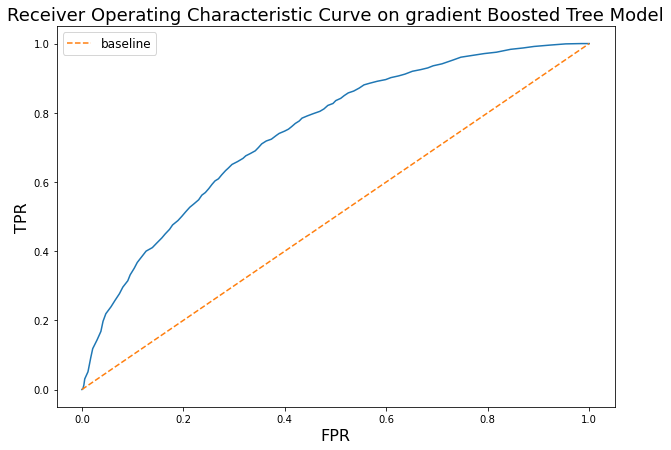

In [79]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve on gradient Boosted Tree Model', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

# Comparing the models:

In our case-study, as we will see, gradient booset tree provides a better accuracy when doing grid cross validation using different set of hyperparameters. The best accuracy result for logistic regression model is **0.591** while the best accuracy for gradient boosted tree model is **0.687**. 

# A note on data leakage:

One of the common mistakes when processing the features or traning the model is about data leakage. It means that information about the test data has been used in the feature engineering (i.g. scaling, capping, feture selection, etc) and it leads to over optimistic accuracy scores followed by disappointing accurace meaure when using the model with real data. 


I was careful to not commit this mistake in the process. 

Another  concerning concerning is selecting features before evaluating cross validation. This is also a kind data of data leakage becuase the label for all data was used when training one of the k folds in cross validation. It has serous impacts on the model. Admitting the impact of this leakage, I followed the convention of machine learning pipeline, given that my home computer is not capable of traning a model with all features.



# Test the model on the actual test set provided by employer

Let's first read the data

In [119]:
test_data = pd.read_csv('C:/Users/mhajiha/Desktop/State Farm/exercise_40_test.csv'
                         ,index_col=None ) 

Drop the feaures that do had only one class in traning data and the model did not provide any inference on them:

In [120]:
cat_feat = ['x39', 'x99']
test_data.drop(cat_feat, axis=1, inplace=True)

Clean the variables with str format having special characters:

In [121]:
x7 = list(test_data['x7'])
x19 = list(test_data['x19'])
x7 = [float(x7[i].replace('%',''))   for i in range(len(test_data))]
x19 = [float(x19[i].replace('$',''))   for i in range(len(test_data))]
test_data['x7'] = x7
test_data['x19'] = x19

I need to make indicator variables out of 4 categorical features whose missing values were not random:

In [122]:
df = test_data.copy()

In [123]:
df[continuous_feat].head(10)

,x1,x2,x4,x5,x6,x7,x8,x9,x10,x11,...,x88,x89,x90,x91,x92,x94,x95,x96,x97,x100
0,4.747627,20.509439,2.299105,-1.815777,-0.752166,0.0098,-3.240309,0.587948,-0.260721,101.113628,...,3.420875,11.553023,5.904644,NaN,12.542333,3.107683,0.533904,12.438759,7.298306,93.567120
1,1.148654,19.301465,1.862200,-0.773707,-1.461276,0.0076,0.443209,0.522113,-1.090886,104.791999,...,0.295234,6.212811,4.876645,-0.848567,7.213829,4.276078,NaN,10.386987,12.527094,98.607486
2,4.986860,18.769675,1.040845,-1.548690,2.632948,-0.0005,-1.167885,5.739275,0.222975,102.109546,...,1.718243,NaN,4.455432,1.143388,10.483928,2.090868,-1.780474,11.328177,11.628247,94.578246
3,3.709183,18.374375,-0.169882,-2.396549,-0.784673,-0.0160,-2.662226,1.548050,0.210141,82.653354,...,0.461637,18.198978,3.947223,0.693646,3.862867,2.643847,1.662240,10.064961,10.550014,100.346261
4,3.801616,20.205541,2.092652,-0.732784,-0.703101,0.0186,0.056422,2.878167,-0.457618,75.036421,...,0.930729,10.014853,1.637334,-0.834763,3.632039,4.074434,NaN,9.255766,12.716137,102.578918
5,1.449185,17.237848,0.998924,0.882350,-1.700730,0.0076,-0.371594,1.269817,-1.433127,78.434085,...,-0.361749,14.582317,4.913132,0.636832,2.990617,3.476341,NaN,10.226547,8.795927,107.472726
6,0.979035,18.056038,0.105417,-1.782850,-1.390759,-0.0045,-1.886515,2.905928,0.222237,87.040247,...,-0.771061,9.040024,3.239272,0.622201,4.563410,4.311061,-1.757497,10.894402,11.669336,97.736258
7,0.910023,17.057286,-0.903745,0.118699,-2.110974,-0.0079,-0.613028,2.109169,1.140936,93.985642,...,0.653846,7.151094,4.587466,-3.446000,5.910630,4.615327,NaN,12.956667,9.710828,103.143976
8,3.616287,17.740881,2.193121,4.222402,0.206030,-0.0201,-0.397257,3.058279,-0.859673,120.832847,...,2.268028,8.720701,4.471586,0.327317,4.247582,6.103622,0.449423,NaN,10.757233,99.305236
9,2.539012,21.078729,-0.868620,-0.193794,1.244369,-0.0222,-0.334661,1.478947,0.637950,88.678380,...,0.009158,NaN,2.784435,-3.202012,2.336352,5.288189,NaN,10.258891,8.016081,99.593899


In [124]:
df[categorical_feat].head(10)

,x3,x24,x31,x33,x59,x60,x65,x77,x79,x93,x98
0,Wednesday,NaN,no,Florida,0,May,progressive,mercedes,1.0,no,0
1,Fri,female,yes,North Carolina,0,July,allstate,ford,1.0,yes,1
2,Saturday,male,no,NaN,0,January,progressive,NaN,1.0,no,0
3,Tuesday,female,no,Mississippi,0,July,geico,subaru,1.0,no,1
4,Monday,female,yes,Georgia,0,January,progressive,ford,0.0,yes,1
5,Sun,female,no,Texas,0,August,allstate,chevrolet,NaN,no,0
6,Monday,female,no,Texas,0,October,allstate,toyota,1.0,no,1
7,Mon,male,no,West Virginia,0,July,allstate,mercedes,0.0,no,0
8,Thur,male,yes,NaN,0,December,progressive,subaru,1.0,no,0
9,Saturday,male,yes,Florida,1,July,progressive,subaru,1.0,no,0


In [125]:
non_random = ['x16', 'x89', 'x96']

In [126]:
indicator_df = pd.DataFrame()
for feature in df.columns:    
    if feature in non_random:
        indicator_df['{}_indicator'.format(feature)] = df[feature].isnull()

    if feature in continuous_feat:
        df[feature] = df[feature].fillna( df[feature].mean())
    if feature in categorical_feat:
        new_array = df[feature].values.reshape(-1,1)
        data_new = my_imputer.fit_transform(new_array)
        df[feature] = data_new


In [127]:
df.head(10)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x100
0,4.747627,20.509439,Wednesday,2.299105,-1.815777,-0.752166,0.0098,-3.240309,0.587948,-0.260721,...,5.904644,-0.003896,12.542333,no,3.107683,0.533904,12.438759,7.298306,0,93.567120
1,1.148654,19.301465,Fri,1.862200,-0.773707,-1.461276,0.0076,0.443209,0.522113,-1.090886,...,4.876645,-0.848567,7.213829,yes,4.276078,0.036814,10.386987,12.527094,1,98.607486
2,4.986860,18.769675,Saturday,1.040845,-1.548690,2.632948,-0.0005,-1.167885,5.739275,0.222975,...,4.455432,1.143388,10.483928,no,2.090868,-1.780474,11.328177,11.628247,0,94.578246
3,3.709183,18.374375,Tuesday,-0.169882,-2.396549,-0.784673,-0.0160,-2.662226,1.548050,0.210141,...,3.947223,0.693646,3.862867,no,2.643847,1.662240,10.064961,10.550014,1,100.346261
4,3.801616,20.205541,Monday,2.092652,-0.732784,-0.703101,0.0186,0.056422,2.878167,-0.457618,...,1.637334,-0.834763,3.632039,yes,4.074434,0.036814,9.255766,12.716137,1,102.578918
5,1.449185,17.237848,Sun,0.998924,0.882350,-1.700730,0.0076,-0.371594,1.269817,-1.433127,...,4.913132,0.636832,2.990617,no,3.476341,0.036814,10.226547,8.795927,0,107.472726
6,0.979035,18.056038,Monday,0.105417,-1.782850,-1.390759,-0.0045,-1.886515,2.905928,0.222237,...,3.239272,0.622201,4.563410,no,4.311061,-1.757497,10.894402,11.669336,1,97.736258
7,0.910023,17.057286,Mon,-0.903745,0.118699,-2.110974,-0.0079,-0.613028,2.109169,1.140936,...,4.587466,-3.446000,5.910630,no,4.615327,0.036814,12.956667,9.710828,0,103.143976
8,3.616287,17.740881,Thur,2.193121,4.222402,0.206030,-0.0201,-0.397257,3.058279,-0.859673,...,4.471586,0.327317,4.247582,no,6.103622,0.449423,10.564081,10.757233,0,99.305236
9,2.539012,21.078729,Saturday,-0.868620,-0.193794,1.244369,-0.0222,-0.334661,1.478947,0.637950,...,2.784435,-3.202012,2.336352,no,5.288189,0.036814,10.258891,8.016081,0,99.593899


Let's encode categorical features that we use: significant_categorical_feat  = ['x31', 'x33', 'x93']

In [128]:
print(unique(df['x31'] )) # Before encoding 
df['x31'] = df['x31'].map({'no':0 ,'yes' : 1})
print(unique(df['x31'] )) # after encoding:

Counter({'no': 8500, 'yes': 1500})
Counter({0: 8500, 1: 1500})


In [129]:
print(unique(df['x33'] )) # Before encoding 
dic = unique(df['x33'])
states = list(dic.keys())
newdic = {x:i  for i,x in enumerate(states)   }
df['x33'] = df['x33'].map(newdic)
print("  ")
print(unique(df['x33'] )) # after encoding:

Counter({'California': 2611, 'Texas': 593, 'Florida': 475, 'New York': 462, 'Pennsylvania': 321, 'Illinois': 306, 'Ohio': 278, 'Michigan': 245, 'North Carolina': 238, 'Georgia': 236, 'New Jersey': 204, 'Washington': 189, 'Virginia': 188, 'Massachusetts': 178, 'Indiana': 162, 'Colorado': 160, 'Tennessee': 157, 'Oklahoma': 153, 'Missouri': 153, 'Alabama': 149, 'Minnesota': 148, 'Wisconsin': 145, 'Maryland': 139, 'South Carolina': 132, 'Arizona': 124, 'Louisiana': 119, 'Kentucky': 114, 'Arkansas': 113, 'Utah': 109, 'Oregon': 102, 'Connecticut': 100, 'Iowa': 89, 'Nevada': 88, 'Kansas': 87, 'Mississippi': 85, 'Nebraska': 77, 'New Hampshire': 73, 'Idaho': 67, 'West Virginia': 65, 'New Mexico': 62, 'Rhode Island': 57, 'Maine': 54, 'South Dakota': 50, 'North Dakota': 48, 'Hawaii': 46, 'Alaska': 45, 'DC': 44, 'Wyoming': 41, 'Vermont': 41, 'Montana': 40, 'Delaware': 38})
  
Counter({2: 2611, 5: 593, 0: 475, 17: 462, 23: 321, 12: 306, 7: 278, 19: 245, 1: 238, 4: 236, 26: 204, 18: 189, 11: 188, 20

In [130]:
df['x93'].nunique()
ans_dict = unique(df['x93'])
ans =  list(ans_dict.keys())
newdic = {x:i  for i,x in enumerate(ans)   }
df['x93'] = df['x93'].map(newdic)


print(unique(df['x93'] )) # after encoding:

Counter({0: 8848, 1: 1152})


In [131]:
# encode the indicator variables:
for feat in indicator_df.columns:
    indicator_df[feat] = indicator_df[feat].map({False:0 ,True : 1})
    

for feat in indicator_df.columns:
    df[feat] = indicator_df[feat]

In [132]:
len(significant_feat)

48

See the significant feature labels as significant_feat:

Imputing the data:

In [133]:
for feat in extereme_high_outlier:
    df[feat].clip(upper=df[feat].quantile(.99), inplace = True)

for feat in both_end_extreme_outlier:
    df[feat].clip(upper=df[feat].quantile(.99), lower =df[feat].quantile(.1), inplace = True)
    

Let's look at the test data:

In [134]:
df = df[significant_feat]
df.head()

,x1,x5,x7,x8,x11,x16,x18,x19,x21,x26,...,x89,x90,x95,x96,x31,x33,x93,x16_indicator,x89_indicator,x96_indicator
0,4.747627,-1.815777,0.0098,-3.240309,101.113628,102.193597,75.256714,120.216190,4.794438,-3.152540,...,11.553023,5.904644,0.533904,12.438759,0,0,0,0,0,0
1,1.148654,-0.773707,0.0076,0.443209,104.791999,99.356609,79.061540,-267.562586,12.377178,-0.442525,...,6.212811,4.876645,0.036814,10.386987,1,1,1,0,0,0
2,4.986860,-1.548690,-0.0005,-1.167885,102.109546,100.727360,87.567827,-311.292903,31.135956,-0.303259,...,10.847434,4.455432,-1.780474,11.328177,0,2,0,1,1,0
3,3.709183,-2.396549,-0.0160,-2.662226,84.256726,102.410965,71.825782,2229.149400,1.822459,0.641209,...,18.198978,3.947223,1.662240,10.064961,0,3,0,0,0,0
4,3.801616,-0.732784,0.0186,0.056422,84.256726,101.513490,74.602441,-469.049530,0.904920,1.841905,...,10.014853,1.637334,0.036814,9.255766,1,4,1,0,0,0


In [135]:
# Fit the scaler on the training data
scaler.fit(df)

StandardScaler()

# Final Prediction

In [136]:
test_preds = gb.predict(X_test)
print(test_preds)

[1 1 0 ... 0 0 1]


In [137]:
preds_df = pd.DataFrame(test_preds, columns = ['predictions'])
preds_df.to_excel("gb_test_predictions.xlsx") 

Column of probabilities for classification on the test set:

In [138]:
gb.predict_proba(X_test)

array([[0.11419279, 0.88580721],
       [0.27910464, 0.72089536],
       [0.75333181, 0.24666819],
       ...,
       [0.56698306, 0.43301694],
       [0.51129794, 0.48870206],
       [0.09429095, 0.90570905]])

Export the result of predictions to xlsx file. The left column is the probabilities of belonging to negative class and the right column is the probablitites of belonging to the positive class. 

In [139]:
probs_df = pd.DataFrame(gb.predict_proba(X_test), columns = ['prob_0','prob_1'])
probs_df.to_excel("gb_test_probabilities.xlsx") 